In [51]:
from functools import partial

import numpy as np
import scipy as sp
import scipy.stats

from sympy import symbols, integrate, solve

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

# 1.
Чтобы получить одну реализацию искомой СВ $\xi$, сперва генерируем выборку из распределения параметра $\theta$ нужного размера. Затем для каждого значения параметра генерируем по одной реализации из соответствующего геометрического распределения.

## a)
$$
\mathcal P = U\left\{ \frac{0}{n}, \frac{1}{n}, \ldots, \frac{n}{n}\right\}
\\   \Rightarrow P(\xi = k) = \int \mathcal \theta^k (1 - \theta ) d \mathcal P(\theta) = 
\sum_{\tau \in \left\{ \frac{0}{n}, \frac{1}{n}, \ldots, \frac{n}{n}\right\}}
\tau^k (1 - \tau) P \{\theta = \tau\} = 
\frac{1}{n + 1} \cdot
\sum_{\tau \in \left\{ \frac{0}{n}, \frac{1}{n}, \ldots, \frac{n}{n}\right\}}
\tau^k (1 - \tau)
$$
Можно посчитать вероятности для первых условно 200 значений (вероятность "хвоста" получается пренебрежимо малой), отнормировать эти вероятности, затем воспользоваться предложенным на давней лекции алгоритмом: генерировать $\eta \sim U(0, 1)$, и возвращать такое значение $\xi$, значение функции вероятности для которого является ближайшим снизу из допустимых.

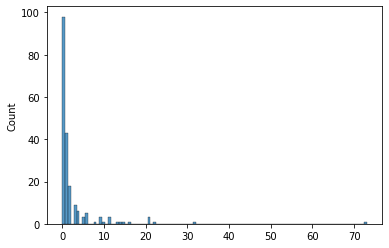

In [46]:
np.random.seed(0)

n = 20
theta_values = np.array([i / n for i in range(0, n + 1)])
def P_ksi(k):
    """Возвращает вероятность того, что ksi = k"""
    prob = 0
    for tau in theta_values:
        prob += tau ** k * (1 - tau)
    return prob / (n + 1)

probability = np.array([P_ksi(i) for i in range(200)])
probability /= np.sum(probability)
cdf = np.cumsum(probability)

N = 200  # объём выборки
sample = np.zeros(N)
distr = sp.stats.uniform(0, 1)
for i in range(N):
    eta = distr.rvs()
    sample[i] = np.searchsorted(cdf, eta)
    
sns.histplot(sample);

## b)
$$
\mathcal P = \text{Beta}(a, b) \\ 
\Rightarrow P(\xi = k) = \int \mathcal \theta^k (1 - \theta ) d \mathcal P(\theta) = 
\int_0^1 \theta^k (1-\theta) f_{a,b} (\theta) d\theta,
$$
где 
$
f_{a, b}(\theta) - \
$ - плотность бета-распределения с параметрами $a, b$.

Решение аналогично предыдущему пункту (только с численным расчётом интеграла).

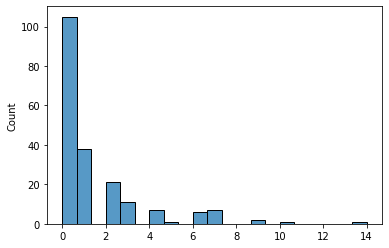

In [58]:
a, b = 3, 3
distr_theta = sp.stats.beta(a, b)

def integrand(tau, k):
    """Подинтегральная функция"""
    return tau**k * (1 - tau) * distr.pdf(tau)

def P_ksi(k):
    return sp.integrate.quad(partial(integrand, k=k), 0, 1)[0]

probability = np.array([P_ksi(i) for i in range(200)])
probability /= np.sum(probability)
cdf = np.cumsum(probability)

N = 200  # объём выборки
sample = np.zeros(N)
distr_uni01 = sp.stats.uniform(0, 1)
for i in range(N):
    eta = distr_uni01.rvs()
    sample[i] = np.searchsorted(cdf, eta)
    
sns.histplot(sample);

# 2.

## a)

$$
p(x, y) = p_\xi (x | \eta = y) \cdot
p_\eta (y) = p_\eta(y| \xi = x) \cdot p_\xi(x) \\
\begin{cases}
p(x, y) = p_\xi(x | \eta = y) \cdot \int p(x, y)dx \\
p(x, y) = p_\eta(y | \xi = x) \cdot \int p(x, y) dy
\end{cases}
$$
$p(x, y)$ определена однозначно, поскольку для любой пары $x, y$ у системы будет существовать однозначное решение (рассматриваем пары $x, y$ из множества значений случайного вектора $(\xi, \eta)$. Это множество значений нам известно, поскольку известны условные плотности).

## b)
Рассмотрим ситуацию, когда $\xi$ и $\eta$ независимы. Тогда $p_\xi(x | \eta = y) = p_\xi(x)$, т.е. из известных плотностей нельзя извлечь никакой информации о распределении $\eta$. Соответственно $p_\eta(y)$ не определена однозначно.

# 3.

Предположим, что случайно названные человеком числа имеют распределение $U(0, 1)$.

Рассмотрим СВ $\xi$ = $\begin{cases} 1, \text{число оказалось меньше загаданного лектором} \\
0, \text{иначе}\end{cases}$

Тогда $\xi \sim Ber(\theta)$, где $\theta$ - число, загаданное лектором; $\pi( \theta) = 
\mathbb 1 (0 \leq \theta \leq 1)$.

Выборка $\mathbb X $ - набор реализаций СВ $\xi$, 
$\mathbb X = \left\{0, 0, 0, 1\right\}$

$$
\pi (\theta | \mathbb X) = \frac{\mathcal L (\mathbb X | \theta) \pi (\theta)}
{\int_0^1 \mathcal L (\mathbb X | \tau) \pi (\tau) d \tau } = 
\frac{\theta \cdot (1 - \theta)^3 \cdot \mathbb 1} 
{\int_0^1 \tau (1 - \tau)^3 d\tau} = 
20 \cdot \theta \cdot (1 - \theta)^3 \cdot \mathbb 1
$$

Т.е. апостериорное распределение $\theta$ - $\text{Beta} (2, 4)$.

Найдём ещё ОМП оценку (в теории это должен быть максимум плотности) и построим графики.

In [91]:
# интеграл в знаменателе
tau = symbols('tau')
integrate(tau * (1 - tau)**3, (tau, 0, 1))

1/20

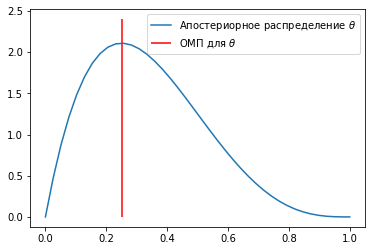

In [102]:
theta_mle = solve((1 - tau)**3 - tau * 3 * (1 - tau)**2)  

x = np.linspace(0, 1, 40)
theta_pdf = sp.stats.beta(2, 4).pdf(x)
ax = sns.lineplot(x=x, y=theta_pdf, label=r'Апостериорное распределение $\theta$');
ax.vlines(float(theta_mle[0]), 0, 2.4, color='red', label=r'ОМП для $\theta$')
ax.legend();

# 4.

Найдём апостериорное распределение $\theta$. Тогда апостериорное распределение $\xi_1$ будем "смесью" биномиальных распределений с "весами", пропорциональными плотности параметра $\theta$ для каждого распределения.

Пусть $\xi_2 = y, f_{a,b}(\theta) = C \theta^{a-1} (1 - \theta)^{b - 1}$ - плотность распределения $\text{Beta}(a, b)$.

$$\pi(\theta | \xi_2) = 
\frac{\mathcal L (\xi_2 | \theta) \pi(\theta)}
{\int_0^1 \mathcal L (\mathbb \xi_2 | \tau) \pi (\tau) d \tau } = 
\frac{{m \choose y}\theta^y(1 - \theta)^{m - y}\cdot C \theta^{a-1} (1 - \theta)^{b - 1}}
{\int_0^1 \mathcal L (\mathbb \xi_2 | \tau) \pi (\tau) d \tau } = 
\frac{{m \choose y} C \theta^{a -1 + y} (1 - \theta)^{b - 1 + m - y}}
{\int_0^1 \mathcal L (\mathbb \xi_2 | \tau) \pi (\tau) d \tau }
$$
Т.к. мы имеем дело с сопряжённым семейством распределений, то апостериорное распределение также является бета-распределением (а точнее,  $\text{Beta}(a + y, b + m - y)$ ). Множители $m \choose y$, $C$ и интеграл в знаменателе задают нормирующий множитель.

Тогда апостериорное распределение $\xi_1$ задаётся следующим образом:

$$
P\{\xi_1 = k\} = {n \choose k} \int_0^1 \theta^k (1 - \theta)^{n - k} f_{a+y,b+m-y}(\theta)d\theta,
$$

где 
$
f_{a+y,b+m-y}(\theta) 
$ - плотность бета-распределения 

# 5.


# 6.

Рассмотрим выборки $\mathbb X_{(1)} = \{1, 0\}$ и $\mathbb X_{(2)} =  \{0, 1\}$. Правдоподобие для них одинаково и равно $0.9 \cdot 0.05$ (т.е. $c$ из формулировки принципа правдоподобия равно $1$). 

Для первой выборки $x_1 = 1 > 0$ и $H_0$ будет отвергнута. Для второй выборки $x_1 = 0$ и $H_0$ отвергнута не будет. Различие выводов не соответствует принципу правдоподобия.  